<center><img src="../meta/TRAIDENT.png" width="200"/></center>

# Preprocessing training-datacubes
---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import xarray as xr
import sys
import os

## Open the zarr dataset 

In [4]:
zarrpath = "/scratch3/users/jdawson/parrot-cube-1-dirty-bad-chunking.zarr"

xrdata = xr.open_dataset(zarrpath, engine='zarr')

cube = xrdata['hdu']

## Get a chunk from the zarr dataset ready for fake signal injection

In [9]:
def getChunk(dataset, rank, blockSize=64):
    dec = (rank * blockSize, rank * blockSize + blockSize)
    ra = (0, 64)
    chunk = cube.isel(**{'DEC--SIN': slice(dec[0], dec[1]), 'RA---SIN': slice(ra[0], ra[1])}).data
    return chunk

In [38]:
chunk = getChunk(cube, 0)
print(f"Size of chunk: {chunk.shape}")

Size of chunk: (4608, 64, 64)


## Define a fake signal injection

In [39]:
def normal_sample(xarray, channel, amplitude, duration):
    ### Creates a normal distribution of points with no scatter
    a = 1 / (duration*np.sqrt(2*np.pi))
    b = np.exp(-0.5 * (((xarray-channel)/duration)**2))
    norm = a * b
    norm = amplitude * norm / norm.max()
    return norm

In [49]:
def inject_fake_signal(cube, row, column, channel, amplitude, duration):
    xarray = np.arange(cube.shape[0]) # Make an empty array of zeros
    pixel = cube[:, row, column] # GET the current pixel timeseries
    rms = np.sqrt((pixel*pixel).sum()/cube.shape[0]) # Calculate the rms of the pixel 
    signal = normal_sample(xarray, channel, amplitude*rms, duration) # Make the clean signal
    signal[pixel == 0] = 0 # Remove signal where original cube == 0
    cube[:, row, column] += signal # Inject the signal into the cube
    return cube

In [50]:
pixel, corrupted = inject_fake_signal(chunk, 30, 30, 1500, 5, 100)

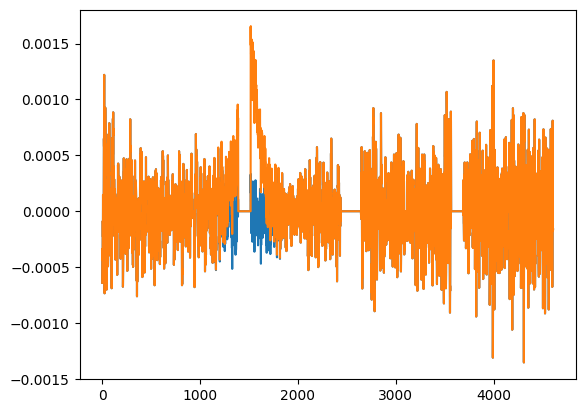

In [51]:
plt.figure()
plt.plot(pixel)
plt.plot(corrupted)